In [2]:
from scipy import stats
import time
import pandas as pd
import json
from bs4 import BeautifulSoup as soup
from tqdm import trange
import re 
from collections import OrderedDict
import datetime
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from mplsoccer.pitch import Pitch
from mplsoccer import Pitch, VerticalPitch, FontManager
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from scipy.spatial import ConvexHull
from highlight_text import fig_text

In [3]:
def whoscored():
    driver = webdriver.Chrome(r'C:\Users\jose\Documents\Data Science\Personal\Soccer\Football analytics\chromedriver.exe')
    website_URL="https://es.whoscored.com/Matches/1559818/Live/Espa%C3%B1a-LaLiga-2021-2022-Barcelona-Real-Sociedad"
    driver.get(website_URL)
    element=driver.find_element_by_xpath('//*[@id="layout-wrapper"]/script[1]')
    script_content=element.get_attribute('innerHTML')
    script_ls=script_content.split(sep="  ")
    script_ls=list(filter(None,script_ls))
    script_ls=[name for name in script_ls if name.strip()]
    dictstring=script_ls[2][17:-2]
    matchdict=json.loads(dictstring)
    matchdict["id"]=script_ls[1][8:-2]
    return matchdict
    driver.close()
data = whoscored()

In [4]:
events_df = pd.DataFrame(data['events'])
ids = data['playerIdNameDictionary']

# Keys from string to int
player_ids = {int(old_key): val for old_key, val in ids.items()}

#Replace player IDs
team_ID = data['home']['teamId']
team_name = data['home']['name']
events_df['PlayerName'] = events_df["playerId"].replace(player_ids)

# Replace team name
events_df['TeamName'] = events_df["teamId"].replace({team_ID : team_name})

# Replace the period
events_df["period"] = events_df["period"].apply(pd.Series)["displayName"].values

# Replace type 
events_df['type'] = events_df["type"].apply(pd.Series)["displayName"].values

# Replace the outcome
events_df['outcomeType'] = events_df["outcomeType"].apply(pd.Series)["displayName"].values

In [5]:
df1 = events_df
df1['y'] = 80-.8*df1['y']
df1['x'] = 1.2*df1['x']
df1 = df1.fillna(0)
df1['playerId'] = df1['playerId'].astype(int) 
df1 = df1[df1['teamId']==65].reset_index()
players = df1['playerId'].unique()
starters = players[0:12]
# Instead of players 
player_names = df1[df1["TeamName"]=="Barcelona"]["PlayerName"].unique()
player_names = player_names[player_names != 0]
starters.sort()
starters = list(starters)
del starters[1]
# Replace type 
df1 = df1[df1["type"]=="Pass"]

# Removing outliers

In [6]:
df1 = df1[["x","y","PlayerName"]]

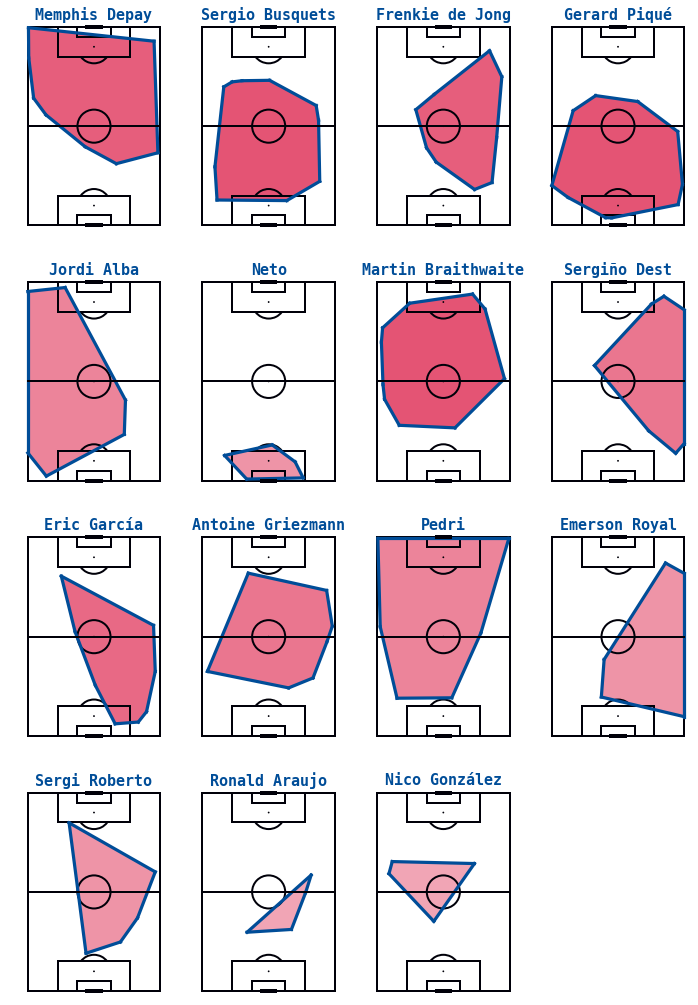

In [32]:
fig, axes = plt.subplots(4,4,figsize=(12,18))
fig.set_facecolor('white')
axes.flat[-1].set_visible(False)
pitch = VerticalPitch(line_color='#000009', line_zorder=2,pitch_color='white')
for i,ax in enumerate(fig.axes):
    try:
        #ax.set_facecolor('#3b3b38')
        pitch.draw(ax=ax)

        df = df1[(df1.PlayerName == player_names[i])]
        #df = df[(np.abs(stats.zscore(df[['x','y']])) < .5)]

        points = df[['y','x']].values
        hull = ConvexHull(df[['y','x']])

        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], '#004D98',lw=3.2)
            ax.fill(points[hull.vertices,0], points[hull.vertices,1], c='#DB0030', alpha=0.1)
            ax.set_ylabel(ylabel=' ')


        ax.set_title(label=player_names[i],c='#004D98',va='center',ha='center',fontsize=15,fontfamily='Monospace',fontweight="bold")
    except:
        pass
#fig_text(.39,.95, s=" FC Barcelona <Pass Territories> vs Real Betis",highlight_textprops=[{"color":'springgreen'}], fontsize = 23, fontweight="bold", color = "black")